In [1]:
# Import Libraries
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
import warnings

#import custom class
from Classes.Mysql_class import Mysql_Class

In [2]:
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# Timeseries Model

In [16]:
# credentials and connection using mysql class developed
mysql_init=Mysql_Class(user = '',
                    host = '',
                    password = '')
engine = mysql_init.create_engine("")

In [23]:
query = """SELECT * FROM FactFinance 
            LEFT JOIN DimScenario ON FactFinance.ScenarioKey = DimScenario.ScenarioKey 
            LEFT JOIN DimDepartmentGroup ON FactFinance.DepartmentGroupKey=DimDepartmentGroup.DepartmentGroupKey
            LEFT JOIN DimOrganization ON FactFinance.OrganizationKey=DimOrganization.OrganizationKey"""
merged_df = pd.read_sql_query(query, engine)

In [24]:
#Drop Columns
merged_df = merged_df.drop(['ScenarioKey','DateKey','FinanceKey','DepartmentGroupKey','AccountKey','OrganizationKey','ParentDepartmentGroupKey','PercentageOfOwnership'],axis=1)

In [26]:
###-------->>>>>  EXECUTE THIS LINE IF YOU DONT HAVE TABLES UPLOADED ON MYSQL <<<<---------
merged_df=pd.read_csv("Data/Merged_dataframes/FactFinance_querry.csv")

In [27]:
merged_df.dtypes

Amount                   float64
Date                      object
ScenarioName              object
DepartmentGroupName       object
ParentOrganizationKey    float64
OrganizationName          object
CurrencyKey                int64
dtype: object

In [29]:
# Date column to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'],errors='coerce')

In [30]:
# Count number of records per department
records_per_department=merged_df['DepartmentGroupName'].value_counts().reset_index()

In [31]:
records_per_department

,DepartmentGroupName,count
0,Research and Development,12003
1,Sales and Marketing,9057
2,Corporate,8843
3,Executive General and Administration,4088
4,Inventory Management,1908
5,Manufacturing,1836
6,Quality Assurance,1674


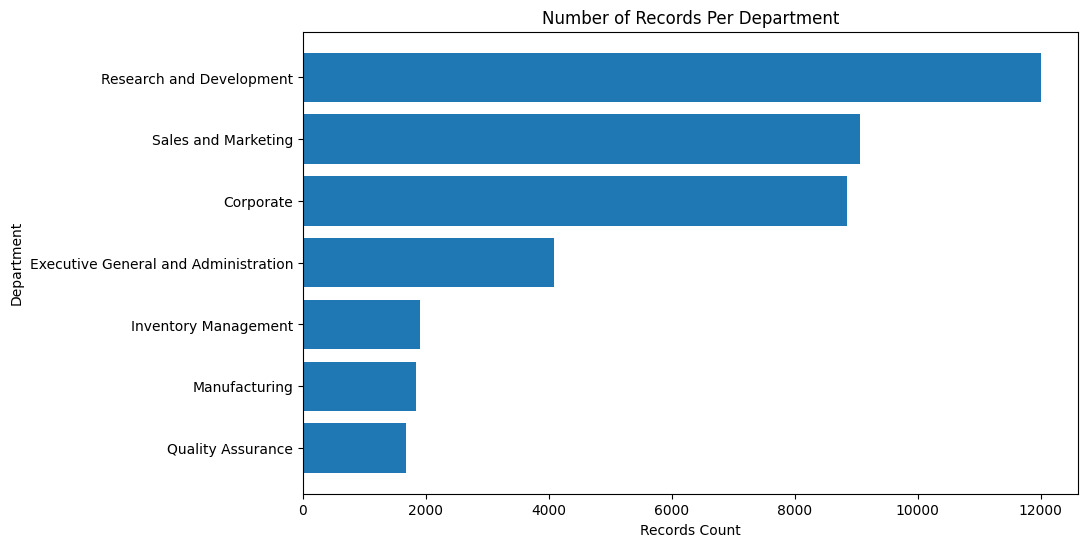

In [32]:
# Horizontal Bar plot records_per_department
plt.figure(figsize=(10, 6))
plt.barh(records_per_department['DepartmentGroupName'], records_per_department['count'])
plt.xlabel('Records Count')
plt.ylabel('Department')
plt.title('Number of Records Per Department')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

In [34]:
# Count records per organization
records_per_organization=merged_df['OrganizationName'].value_counts().reset_index()

In [35]:
records_per_organization

,OrganizationName,count
0,Southeast Division,8688
1,Canadian Division,5137
2,Northeast Division,5127
3,France,4663
4,Southwest Division,3921
5,Central Division,3913
6,Northwest Division,3911
7,Germany,2647
8,Australia,1402


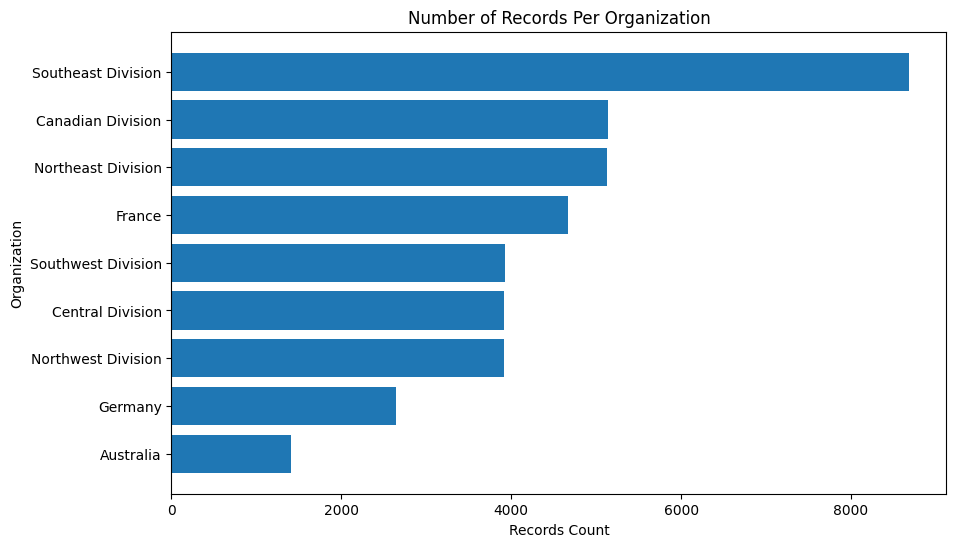

In [36]:
# Horizontal Bar records_per_organization
plt.figure(figsize=(10, 6))
plt.barh(records_per_organization['OrganizationName'], records_per_organization['count'])
plt.xlabel('Records Count')
plt.ylabel('Organization')
plt.title('Number of Records Per Organization')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

In [37]:
# Count scenario name
scenario_count=merged_df['ScenarioName'].value_counts().reset_index()

In [38]:
scenario_count

,ScenarioName,count
0,Actual,34563
1,Budget,4846


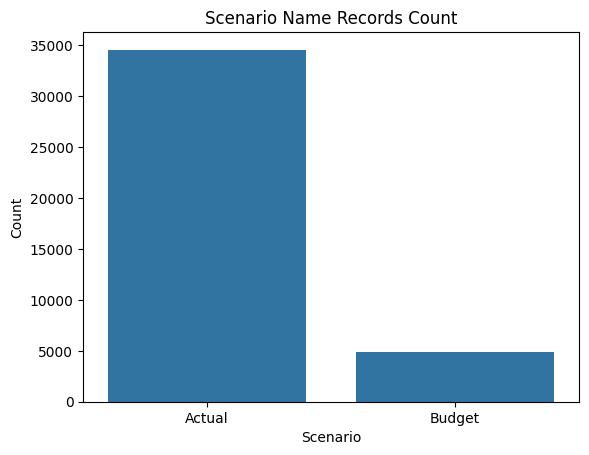

In [39]:
# Scenario Name Bar plot
sns.barplot(x='ScenarioName', y='count', data=scenario_count)

# Adding labels and title for clarity
plt.xlabel('Scenario')
plt.ylabel('Count')
plt.title('Scenario Name Records Count')

# Display the plot
plt.show()

In [40]:
# Check if there are more that 1 currency keys
list(merged_df['CurrencyKey'].unique())

[100, 19, 36, 6]

In [41]:
#Printing Max and min order dates
print("Minimum Record Date:", merged_df['Date'].min().strftime('%Y-%m-%d'))
print("Maximum Record Date:", merged_df['Date'].max().strftime('%Y-%m-%d'))

Minimum Record Date: 2005-07-01
Maximum Record Date: 2008-06-30


In [42]:
southeast_division=merged_df[merged_df['OrganizationName'] == 'Southeast Division']

In [43]:
# Check if there are more that 1 currency keys
list(southeast_division['CurrencyKey'].unique())

[100]

In [44]:
# Filter only Actual Amount
southeast_division_actual=southeast_division[southeast_division['ScenarioName']=='Actual']

In [45]:
southeast_division_actual

,Amount,Date,ScenarioName,DepartmentGroupName,ParentOrganizationKey,OrganizationName,CurrencyKey
470,20800.0,2005-07-01,Actual,Corporate,14.0,Southeast Division,100
473,2080.0,2005-07-01,Actual,Corporate,14.0,Southeast Division,100
474,1040.0,2005-07-01,Actual,Corporate,14.0,Southeast Division,100
477,218.0,2005-07-01,Actual,Corporate,14.0,Southeast Division,100
478,198.0,2005-07-01,Actual,Corporate,14.0,Southeast Division,100
...,...,...,...,...,...,...,...
38723,-58833.0,2008-06-01,Actual,Sales and Marketing,14.0,Southeast Division,100
38724,29624.0,2008-06-01,Actual,Sales and Marketing,14.0,Southeast Division,100
39385,-105.0,2008-06-30,Actual,Sales and Marketing,14.0,Southeast Division,100
39386,945.0,2008-06-30,Actual,Sales and Marketing,14.0,Southeast Division,100


In [46]:
# Groupby Date and Amount
result_df = southeast_division_actual.groupby('Date')['Amount'].sum().reset_index()

In [47]:
# Convert 'Date' to the first day of the month
result_df['Month'] = result_df['Date'].dt.to_period('M').dt.to_timestamp()

# Group by the new 'Month' column and sum the 'Amount'
result_df = result_df.groupby('Month')['Amount'].sum().reset_index()

# Rename 'Month' back to 'Date' if needed
result_df.rename(columns={'Month': 'Date'}, inplace=True)

In [48]:
# Copy df
result_df_copy=result_df.copy()

In [49]:
# set date as index
result_df_copy.set_index('Date',inplace=True)

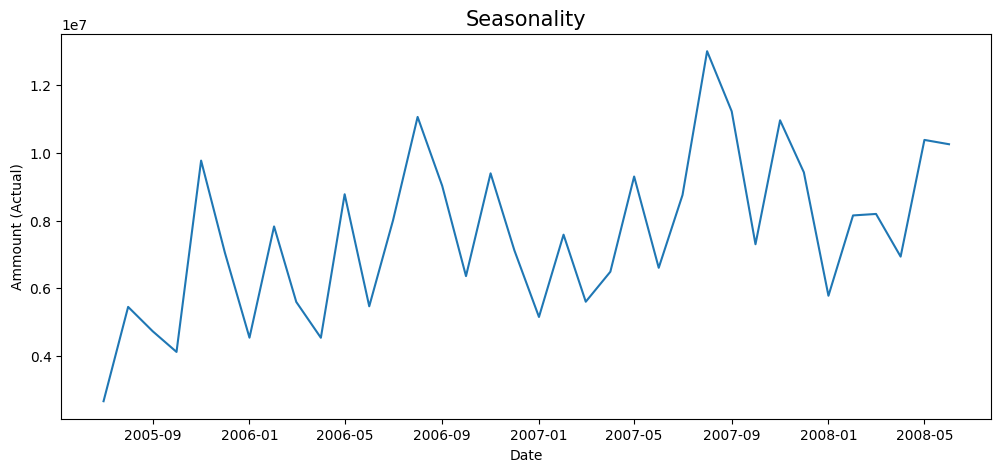

In [50]:
#plot seasonality
plt.figure(figsize=(12,5))
plt.plot(result_df_copy)
plt.title('Seasonality',fontsize=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Ammount (Actual)', fontsize=10)
plt.show()

In [51]:
# prepare df for prophet
prophetdf=result_df
prophetdf.columns=['ds','y']

In [52]:
prophetdf

,ds,y
0,2005-07-01,2655171.0
1,2005-08-01,5445318.0
2,2005-09-01,4724012.0
3,2005-10-01,4113168.0
4,2005-11-01,9772804.0
5,2005-12-01,7047815.0
6,2006-01-01,4534717.0
7,2006-02-01,7824943.0
8,2006-03-01,5592039.0
9,2006-04-01,4532054.0


### 6 Months Prediction

In [53]:
# model = Prophet(yearly_seasonality=True,weekly_seasonality=False)
model = Prophet(seasonality_mode='multiplicative')
model.fit(result_df)
future=model.make_future_dataframe(periods=6,freq="M")
forecast=model.predict(future)

09:54:09 - cmdstanpy - INFO - Chain [1] start processing
09:54:09 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
36,2008-06-30,1.025040e+07,9.119666e+06,1.149720e+07
37,2008-07-31,1.548720e+07,1.433419e+07,1.664986e+07
38,2008-08-31,1.375703e+07,1.268856e+07,1.484195e+07
39,2008-09-30,8.601979e+06,7.439108e+06,9.796970e+06
40,2008-10-31,1.125653e+07,1.005607e+07,1.227824e+07
41,2008-11-30,1.224058e+07,1.104615e+07,1.335992e+07


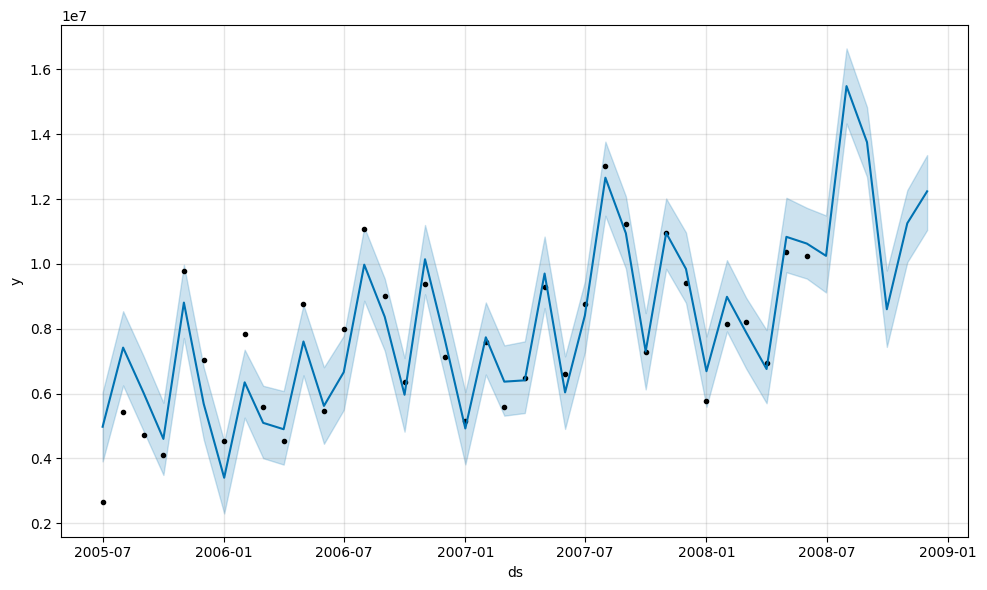

In [56]:
# Plot Forecast
plot=model.plot(forecast)